In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

## Solving the System of Equations

$\ddot{r} = - g$

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 =  -g$

In [2]:
class UniformGravity(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, sparse = 1.0, g = 1.0):
        
        super(UniformGravity, self).__init__()
        
        self.max_thrust = 2.0
        self.dt = 0.1
        self.g = g
        self.target_alt = 1.0
        self.max_time = 10.0
        self.max_steps = int(self.max_time/self.dt)
        self.sparse = sparse
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([-self.max_thrust]), 
                                           high=np.array([self.max_thrust]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0,0]), 
                                                high=np.array([10**3,10**3]), 
                                                dtype=np.float32)
        
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Translational Coordinates
        self.r = 0.0
        self.r_dot = 0.0
        self.r_double_dot = 0.0
 
        obs = np.array([self.r,self.r_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        
        # actions segragation
        thrust = np.clip(action[0]*self.max_thrust, -self.max_thrust, self.max_thrust)

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = -self.g + thrust
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = -self.g + thrust
         
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = -self.g + thrust
          
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = -self.g + thrust

        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y1_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot])
        
        reward = np.exp(-self.sparse*(self.r - self.target_alt)**2)
        
        # set if at the terminal state
        done = False
        
        if self.r < 0.0:
            reward = 0.0
            done = True
        
        if (self.steps > self.max_steps):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        pass

## Example Polices

In [253]:
trajs = []
traja = []

env = UniformGravity()

for T in np.linspace(0,100,10):
    R = 0.0
    s = env.reset()
    
    traj = []
    for t in range(100):
        traj.append(s[0])
        if t < T:
            a = 1.0
        else:
            a = 0.0    
        s,r,d, _ = env.step([a])
        R += r
    trajs.append(traj)
    traja.append((T,R))
    
trajs = np.array(trajs)
traja = np.array(traja)

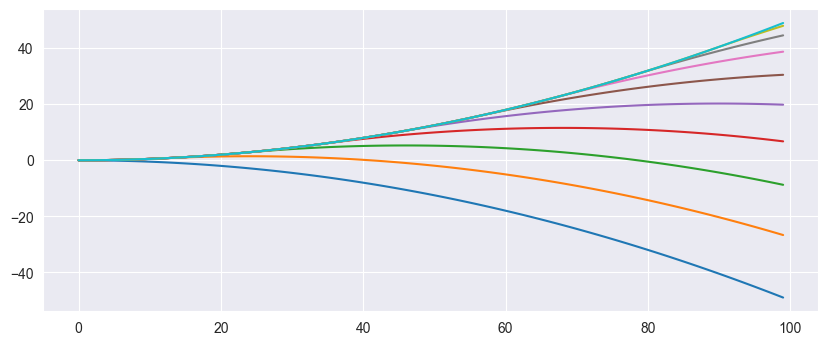

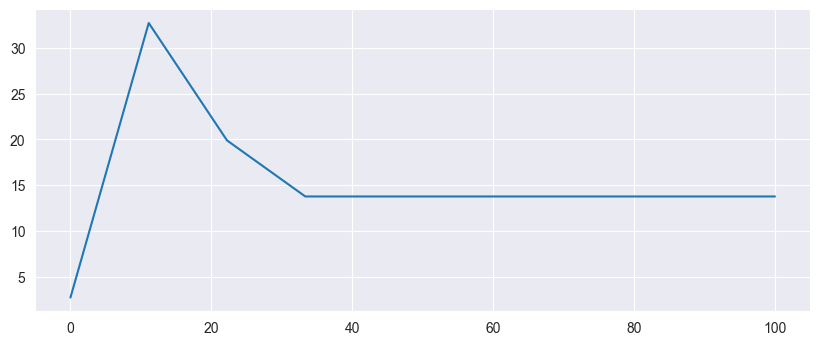

In [254]:
plt.figure(figsize=(10,4), dpi=100);
plt.plot(trajs.T);
plt.show();

plt.figure(figsize=(10,4), dpi=100);
plt.plot(traja[:,0], traja[:,1]);

## Linear Controller Baseline

In [32]:
R = 0.0
s = env.reset()

traj = []
while True:
    traj.append(s[0])
    a = -(s[0] - 1.0)
    s,r,d, _ = env.step([a])
    R += r
    if d:
        break
R

30.232807077550998

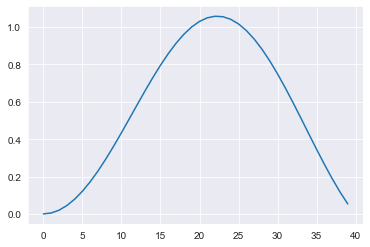

In [34]:
plt.plot(traj);

## Vanilla Policy Gradient Method

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: ',device)

HIDDEN_SIZE = 128

class PGN(nn.Module):
    def __init__(self, in_size, a_size):
        super(PGN,self).__init__()
        
        self.base = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU()
        )
        
        self.actions_mu = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, a_size),
            nn.Tanh() #nn.Hardtanh()
        )
    
        self.actions_var = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, a_size),
            nn.Softplus()
        )
        
        self.value = nn.Linear(HIDDEN_SIZE, 1)
    
    def forward(self, x):
        x = self.base(x)
        return (self.actions_mu(x), self.actions_var(x), self.value(x))
    
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states):
        states_v = torch.FloatTensor(states).to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        
        mu = mu_v.data.cpu().numpy()[0]
        sigma = torch.sqrt(var_v).data.cpu().numpy()[0]
        actions = np.random.normal(mu, sigma)
        return actions

using device:  cuda


In [7]:
def compute_discounted_rewards(epi_rewards):
    batch_R = []
    R = 0.0
    for r in reversed(epi_rewards):
        R = r + GAMMA*R
        batch_R.append(R)
    q = list(reversed(batch_R))
    return q
    
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [16]:
env = UniformGravity(sparse = 1.0, g = 1.0)

C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [17]:
net = PGN(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
agent = AgentA2C(net, device=device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
states = env.reset()

states_v = torch.FloatTensor([states]).to(device)

mu_v, var_v, _ = net(states_v)
mu = mu_v.data.cpu().numpy()[0]
sigma = torch.sqrt(var_v).data.cpu().numpy()[0]

actions = np.random.normal(mu, sigma)
actions

array([0.64373098])

In [28]:
ENTROPY_BETA = 0.01
GAMMA = 0.99
BATCH_SIZE = 256
LEARNING_RATE = 1e-5

REPLAY_SIZE = 500000
REPLAY_INITIAL = 10000

TEST_ITERS = 1000

batch_states, batch_actions, batch_R = [], [], []
batch_rewards = []

total_rewards = collections.deque(maxlen=100)
batch_episodes = 0
done_episodes = 0
step_idx = 0
episode_length = 0

state = env.reset()

while True:
    step_idx += 1
    episode_length += 1
    
    # select an action based on the current policy
    a = agent([state])
    new_state, r, done, _ = env.step(a)

    # store the experience
    batch_states.append(state)
    batch_actions.append(a)
    batch_rewards.append(r)

    if done:
        discounted_rewards = compute_discounted_rewards(batch_rewards)
        batch_R.extend(discounted_rewards)
        
        new_reward = np.sum(batch_rewards)
        total_rewards.append(new_reward)
        
        batch_rewards.clear()
        batch_episodes += 1
        done_episodes += 1
        
        state = env.reset()
        
        mean_rewards = np.mean(total_rewards)
        if done_episodes % 1000 == 0:
            print("%d: reward: %6.2f, mean_100: %6.2f, entropy: %6.2f, episodes: %d, epi_length: %d" % (
                        step_idx, new_reward, mean_rewards, ENTROPY_BETA, done_episodes, episode_length))
        
        if mean_rewards > 90.0:
            print('Solved in %d steps and in %d eps'%(step_idx, done_episodes))
            break
        
        episode_length = 0
    else:
        state = new_state


    if batch_episodes < BATCH_SIZE:
        continue
    
    # done acquiring events, time to train
    batch_episodes = 0    
    
    optimizer.zero_grad()
    
    batch_state_v = torch.FloatTensor(batch_states).to(device)
    batch_actions_v = torch.FloatTensor(batch_actions).to(device)
    batch_R_v = torch.FloatTensor(batch_R).to(device)
    
    mu_v, var_v, values_v = net(batch_state_v)
    
    loss_value_v = F.mse_loss(values_v.squeeze(-1), batch_R_v)
    
    adv_v = batch_R_v.unsqueeze(dim=-1) - values_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, batch_actions_v)
    loss_policy_v = -log_prob_v.mean()
    
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v = ENTROPY_BETA * ent_v.mean()

    loss_v = loss_policy_v + entropy_loss_v + loss_value_v
    loss_v.backward()
    
    optimizer.step()
    
    
    ENTROPY_BETA = np.max([1e-5,0.9*ENTROPY_BETA])
    
    batch_states.clear()
    batch_actions.clear()
    batch_R.clear()

Solved in 101 steps and in 1 eps


In [29]:
rewards = 0.0
steps = 0
count = 1

trajectories = []
trajectories_act = []

# play count episodes
for _ in range(count):
    state = env.reset()
    traj = [state]
    traj_act = []
    print('----')
    while True:
        obs_v = ptan.agent.float32_preprocessor([state])
        obs_v = obs_v.to(device)
        mu_v,_,_ = net(obs_v)
        action = mu_v.squeeze(dim=0).data.cpu().numpy()
        state, reward, done, _ = env.step(action)
        traj.append(state)
        traj_act.append(action[0])
        #print('\t',action)
        rewards += reward
        steps += 1
        if done:
            break
    trajectories.append(traj)
    trajectories_act.append(traj_act)

trajectories = np.array(trajectories)
trajectories_act = np.array(trajectories_act)
(rewards / count, steps / count)

----


(94.14770813617092, 101.0)

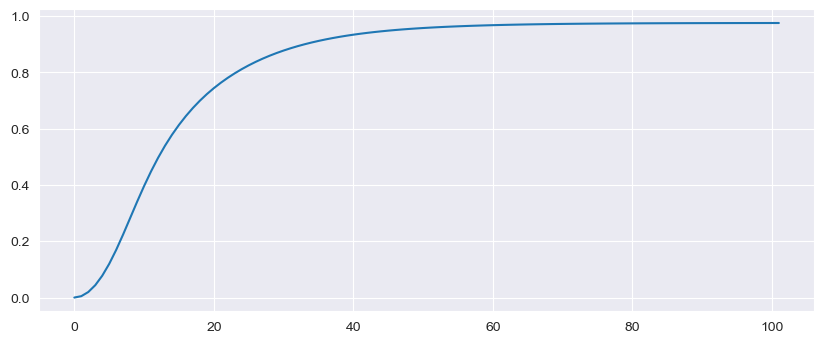

In [30]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories[:,:,0].T );

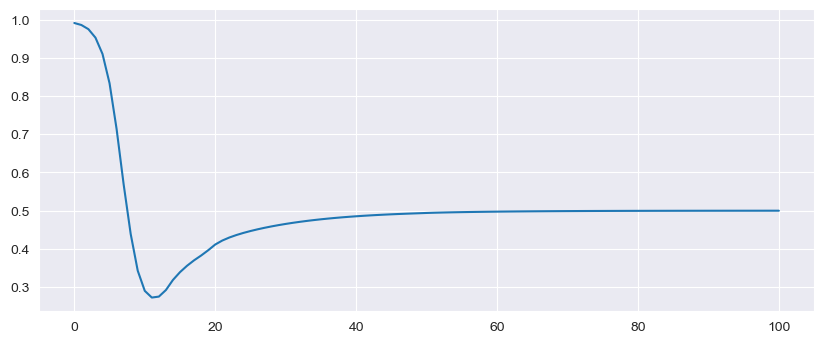

In [31]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories_act.T );

## DDPGN Method

In [35]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    # play count episodes
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)
            mu_v = net(obs_v)
            mu_v = torch.clamp(mu_v, min=-env.max_thrust, max=env.max_thrust)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            state, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    
    states_v = torch.FloatTensor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)
    rewards_v =  torch.FloatTensor(rewards).to(device)
    last_states_v = torch.FloatTensor(last_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)
    
    return states_v, actions_v, rewards_v, dones_t, last_states_v

In [36]:
HIDDEN_SIZE = 128

# pi(s) = action, deterministic no probablity on the action given a state
class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, act_size)
        )

    def forward(self, x):
        return self.net(x)

# Q(s,a) - Q function for a given s, a
class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size): # act size is the dimension of an action vector
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + act_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))

In [37]:
class AgentDDPG(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu", epsilon = 0.0):
        self.net = net
        self.device = device
        self.epsilon = epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):        
        states_v = torch.FloatTensor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()
        
        if np.random.random() < self.epsilon:
            actions = 2.*np.random.random(actions.shape) - 1.0
        #actions = actions + self.epsilon*np.random.normal(size=len(actions))
        
        new_a_states = agent_states
        return actions, new_a_states

In [38]:
GAMMA = 0.99
BATCH_SIZE = 256
LEARNING_RATE = 1e-4

REPLAY_SIZE = 500000
REPLAY_INITIAL = 10000

TEST_ITERS = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = UniformGravity(g = 0.0)
test_env = UniformGravity(g = 0.0)

act_net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
crt_net = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0]).to(device)

tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)

agent = AgentDDPG(act_net, device=device, epsilon = 1.0)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)

#buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)
buffer = ptan.experience.PrioReplayBufferNaive(exp_source, buf_size=REPLAY_SIZE, prob_alpha=0.6)

act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [269]:
frame_idx = 0
best_reward = None

while True:
    frame_idx += 1
    buffer.populate(1)
    
    if len(buffer) < REPLAY_INITIAL:
        continue
    
    batch, batch_indices, batch_priorities = buffer.sample(BATCH_SIZE)
    states_v, actions_v, rewards_v, dones_mask, last_states_v = unpack_batch_ddqn(batch, device)
    break
    # train critic
    crt_opt.zero_grad()

    q_v = crt_net(states_v, actions_v)
    last_act_v = tgt_act_net.target_model(last_states_v)
    
    q_last_v = tgt_crt_net.target_model(last_states_v, last_act_v)
    q_last_v[dones_mask] = 0.0
    q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * GAMMA

    critic_loss_v = (q_v-q_ref_v.detach())**2
    
    buffer.update_priorities(batch_indices, batch_priorities)
    
    critic_loss_v = critic_loss_v.mean()
    critic_loss_v.backward()
    crt_opt.step()
    

    # train actor
    act_opt.zero_grad()

    cur_actions_v = act_net(states_v)
    actor_loss_v = -crt_net(states_v, cur_actions_v)
    actor_loss_v = actor_loss_v.mean()

    actor_loss_v.backward()
    act_opt.step()

    tgt_act_net.alpha_sync(alpha = 1. - 1e-4)
    tgt_crt_net.alpha_sync(alpha = 1. - 1e-4)

    if frame_idx % TEST_ITERS == 0:
        #tgt_act_net.sync()
        #tgt_crt_net.sync()
        
        ts = time.time()
        rewards, steps = test_net(act_net, test_env, device=device)
        print("Test done in %.2f sec, reward %.3f, epsilon %.3f, steps %d" % (time.time() - ts, rewards, agent.epsilon, steps))
        
        agent.epsilon = np.max([0.001, 0.99*agent.epsilon])
        
        if best_reward is None or best_reward < rewards:
            if best_reward is not None:
                print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
            best_reward = rewards

In [214]:
rewards = 0.0
steps = 0
count = 10

trajectories = []
trajectories_act = []

# play count episodes
for _ in range(count):
    state = env.reset()
    traj = [state]
    traj_act = []
    #print('----')
    while True:
        obs_v = torch.FloatTensor([state]).to(device)
        mu_v = act_net(obs_v)
        action = mu_v.data.cpu().numpy()[0]
        state, reward, done, _ = env.step(action)
        traj.append(state)
        traj_act.append(action[0])
        #print('\t',action)
        rewards += reward
        steps += 1
        if done:
            break
    trajectories.append(np.array(traj))
    trajectories_act.append(np.array(traj_act))

trajectories = np.array(trajectories)
trajectories_act = np.array(trajectories_act)
(rewards / count, steps / count)

(19.553723334376176, 101.0)

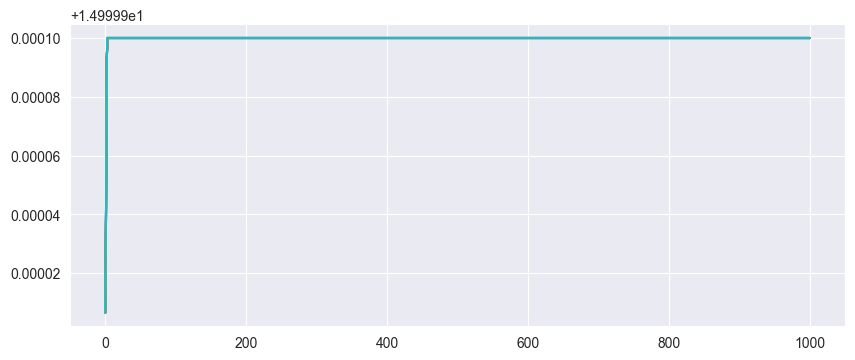

In [161]:
plt.figure(figsize=(10,4), dpi=100)
for traj_act in trajectories_act:
    plt.plot( traj_act*env.max_thrust );

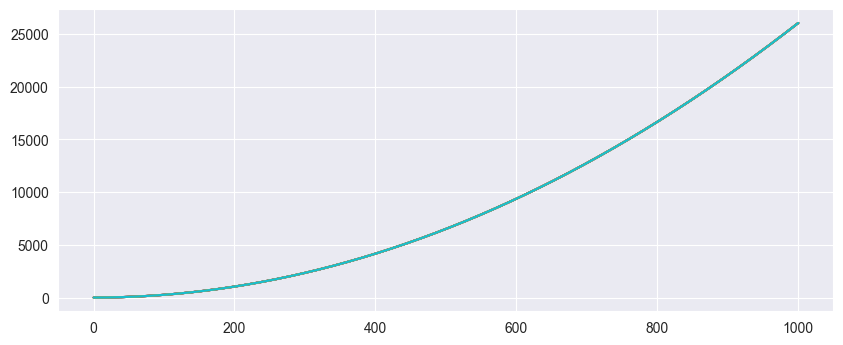

In [162]:
plt.figure(figsize=(10,4), dpi=100)
for traj in trajectories:
    plt.plot(traj[:,0])

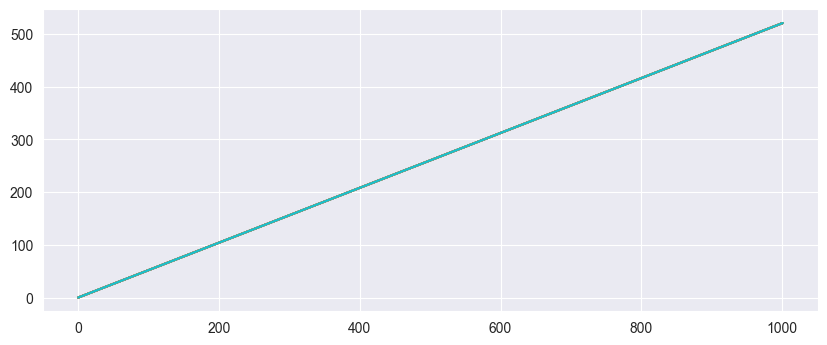

In [163]:
plt.figure(figsize=(10,4), dpi=100)
for traj in trajectories:
    plt.plot(traj[:,1])